In [1]:
from models.cifrador_homomorfico_parcial import CifradorHomomorficoParcial
from models.cifrador_homomorfico_completo import CifradorHomomorficoCompleto
from models.cifrador_asimetrico import CifradorAsimetrico
import time
import random
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Las librerías de seaborn tiran un warning, puse esta celda para ignorarlas
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def wrapped(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        elapsed = end - start
        return result, elapsed

    return wrapper

In [4]:
@wrapped
def encriptar(cifrador, numero):
    return cifrador.encriptar(numero)


@wrapped
def desencriptar(cifrador, numero):
    return cifrador.desencriptar(numero)


@wrapped
def suma(numero1, numero2):
    return numero1 + numero2


@wrapped
def resta(numero1, numero2):
    return numero1 - numero2


@wrapped
def multiplicacion(numero1, numero2):
    return numero1 * numero2

In [5]:
def tiempos_operacion_cifrador(cifrador, numeros, operacion):
    tiempos = []
    numeros_operacion = []
    for numero in numeros:
        numero_operado, elapsed_time = operacion(cifrador, numero)
        tiempos.append(elapsed_time)
        numeros_operacion.append(numero_operado)
    return tiempos, numeros_operacion


def tiempos_operaciones_algebraicas(numeros1, numeros2, operacion):
    if len(numeros1) != len(numeros2):
        raise ValueError("Las listas de numeros tienen diferentes longitudes")
    tiempos = []
    numeros_operacion = []
    for numero1, numero2 in zip(numeros1, numeros2):
        numero_operado, elapsed_time = operacion(numero1, numero2)
        tiempos.append(elapsed_time)
        numeros_operacion.append(numero_operado)
    return tiempos, numeros_operacion

In [6]:
def tiempos_cifrado(cifrador, numeros):
    return tiempos_operacion_cifrador(cifrador, numeros, encriptar)


def tiempos_descifrado(cifrador, numeros_encriptados):
    return tiempos_operacion_cifrador(cifrador, numeros_encriptados, desencriptar)


def tiempos_suma(numeros1, numeros2):
    return tiempos_operaciones_algebraicas(numeros1, numeros2, suma)


def tiempos_resta(numeros1, numeros2):
    return tiempos_operaciones_algebraicas(numeros1, numeros2, resta)


def tiempos_multiplicacion(numeros1, numeros2):
    return tiempos_operaciones_algebraicas(numeros1, numeros2, multiplicacion)

In [7]:
def guardar_plot(titulo):
    %matplotlib inline
    titulo_archivo = titulo.lower().replace(' ', '_').replace('\n','')
    plt.savefig(os.getcwd() + f'/imagenes/{titulo_archivo}.png')

In [8]:
def histplot_tiempos(tiempos, titulo, xlabel):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))

    sns.histplot(tiempos, bins=10, kde=True, color='skyblue', stat='count', edgecolor='black')

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title(titulo, fontsize=16)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    guardar_plot(titulo)
    plt.show()

In [9]:
def boxplot_precision(metodo, tradicional, labels, titulo, xlabel, ylabel):
    # Calculate relative errors for each method
    relative_errors = []
    for method in metodo:
        relative_error = np.array(method) - np.array(tradicional)
        relative_errors.append(relative_error)

    plt.boxplot(relative_errors, labels=labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo)

    guardar_plot(titulo)

    plt.show()

In [10]:
def barplot_tiempos(titulo, averages, tags, ylabel, colores=None, escala_log=False):
    plt.bar(tags, averages, color=colores, edgecolor='black', linewidth=1.2)

    if escala_log: plt.yscale('log')
    plt.ylabel(ylabel)
    plt.title(titulo, fontsize=14, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)

    for i, v in enumerate(averages):
        plt.text(i, v, f'{v:.2e}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    guardar_plot(titulo)

    plt.show()

# Análisis de tiempos de cifrado

Generamos los números aleatorios

In [11]:
random.seed(42)
numeros_random_enteros = [random.randint(1, 10000) for _ in range(500)]
numeros_random_floats = [random.uniform(1.0, 10000.0) for _ in range(500)]

Instanciamos los cifradores

In [12]:
cifrador_homomorfico_parcial = CifradorHomomorficoParcial()
cifrador_homomorfico_completo_bfv = CifradorHomomorficoCompleto()
cifrador_homomorfico_completo_ckks = CifradorHomomorficoCompleto(context_gen_params='CKKS')
cifrador_homomorfico_asimetrico_rsa = CifradorAsimetrico()

Encriptamos con los distintos cifradores y tomamos el tiempo

In [13]:
ruta_archivo = os.getcwd() + '/datos/datos_encriptados.pkl'

if os.path.exists(ruta_archivo):
    print('Cargamos los datos')
    with open(ruta_archivo, 'rb') as file:
        loaded_data = pickle.load(file)

    tiempos_del_parcial, numeros_encriptados_parcial = loaded_data['tiempos_del_parcial'], loaded_data[
        'numeros_encriptados_parcial']
    tiempos_del_completo_bfv, numeros_encriptados_completo_bfv = loaded_data['tiempos_del_completo_bfv'], loaded_data[
        'numeros_encriptados_completo_bfv']
    tiempos_del_completo_ckks, numeros_encriptados_completo_ckks = loaded_data['tiempos_del_completo_ckks'], \
        loaded_data['numeros_encriptados_completo_ckks']
    tiempos_del_asimetrico_rsa, numeros_encriptados_asimetricos_rsa = loaded_data['tiempos_del_asimetrico_rsa'], \
        loaded_data['numeros_encriptados_asimetricos']
else:
    print('Creamos los datos')
    tiempos_del_parcial, numeros_encriptados_parcial = tiempos_cifrado(cifrador_homomorfico_parcial,
                                                                       numeros_random_floats)
    tiempos_del_completo_bfv, numeros_encriptados_completo_bfv = tiempos_cifrado(cifrador_homomorfico_completo_bfv,
                                                                                 numeros_random_enteros)
    tiempos_del_completo_ckks, numeros_encriptados_completo_ckks = tiempos_cifrado(cifrador_homomorfico_completo_ckks,
                                                                                   numeros_random_floats)
    tiempos_del_asimetrico_rsa, numeros_encriptados_asimetricos_rsa = tiempos_cifrado(cifrador_homomorfico_asimetrico_rsa,
                                                                                      numeros_random_enteros)

    data = {'tiempos_del_parcial': tiempos_del_parcial,
            'numeros_encriptados_parcial': numeros_encriptados_parcial,
            'tiempos_del_completo_bfv': tiempos_del_completo_bfv,
            'numeros_encriptados_completo_bfv': numeros_encriptados_completo_bfv,
            'tiempos_del_completo_ckks': tiempos_del_completo_ckks,
            'numeros_encriptados_completo_ckks': numeros_encriptados_completo_ckks,
            'tiempos_del_asimetrico_rsa': tiempos_del_asimetrico_rsa,
            'numeros_encriptados_asimetricos': numeros_encriptados_asimetricos_rsa
            }

    with open(ruta_archivo, 'wb+') as file:
        pickle.dump(data, file)

Creamos los datos


Comparamos los tiempos

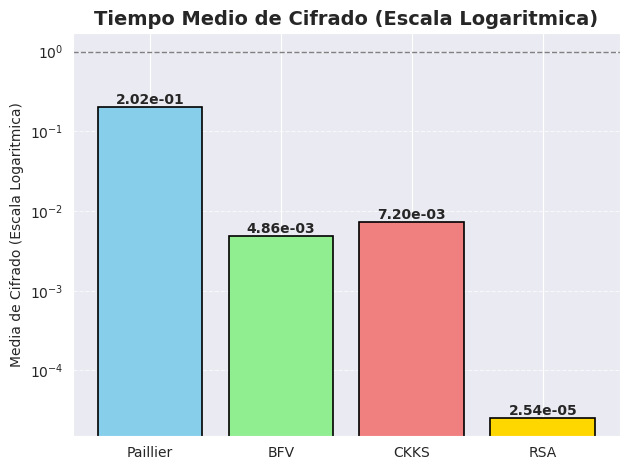

In [14]:
media_encriptado_paillier = np.mean(tiempos_del_parcial)
media_encriptado_bfv = np.mean(tiempos_del_completo_bfv)
media_encriptado_ckks = np.mean(tiempos_del_completo_ckks)
media_encriptado_rsa = np.mean(tiempos_del_asimetrico_rsa)

# Create bar plot with logarithmic scale
tags = ['Paillier', 'BFV', 'CKKS', 'RSA']
averages = [media_encriptado_paillier, media_encriptado_bfv, media_encriptado_ckks, media_encriptado_rsa]

titulo = 'Tiempo Medio de Cifrado (Escala Logaritmica)'
colores = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
ylabel = 'Media de Cifrado (Escala Logaritmica)'

barplot_tiempos(titulo, averages, tags, ylabel, colores=colores, escala_log=True)

# Análisis de tiempos para desencriptar

In [16]:
ruta_archivo = os.getcwd() + '/datos/datos_desencriptados.pkl'

if os.path.exists(ruta_archivo):
    print('Cargamos los datos')
    with open(ruta_archivo, 'rb') as file:
        loaded_data = pickle.load(file)

    tiempos_desencriptado_parcial, numeros_desencriptados_parcial = loaded_data['tiempos_desencriptado_parcial'], \
        loaded_data['numeros_desencriptados_parcial']
    tiempos_desencriptado_completo_bfv, numeros_desencriptados_completo_bfv = loaded_data[
        'tiempos_desencriptado_completo_bfv'], loaded_data['numeros_desencriptados_completo_bfv']
    tiempos_desencriptado_completo_ckks, numeros_desencriptados_completo_ckks = loaded_data[
        'tiempos_desencriptado_completo_ckks'], loaded_data['numeros_desencriptados_completo_ckks']
    tiempos_desencriptado_asimetrico_rsa, numeros_desencriptados_asimetrico_rsa = loaded_data[
        'tiempos_desencriptado_asimetricos'], loaded_data['numeros_desencriptados_asimetricos']

else:
    print('Creamos los datos')
    tiempos_desencriptado_parcial, numeros_desencriptados_parcial = tiempos_descifrado(cifrador_homomorfico_parcial,
                                                                                       numeros_encriptados_parcial)
    tiempos_desencriptado_completo_bfv, numeros_desencriptados_completo_bfv = tiempos_descifrado(
        cifrador_homomorfico_completo_bfv, numeros_encriptados_completo_bfv)
    tiempos_desencriptado_completo_ckks, numeros_desencriptados_completo_ckks = tiempos_descifrado(
        cifrador_homomorfico_completo_ckks, numeros_encriptados_completo_ckks)
    tiempos_desencriptado_asimetrico_rsa, numeros_desencriptados_asimetrico_rsa = tiempos_descifrado(
        cifrador_homomorfico_asimetrico_rsa, numeros_encriptados_asimetricos_rsa)

    data = {
        'tiempos_desencriptado_parcial': tiempos_desencriptado_parcial,
        'numeros_desencriptados_parcial': numeros_desencriptados_parcial,
        'tiempos_desencriptado_completo_bfv': tiempos_desencriptado_completo_bfv,
        'numeros_desencriptados_completo_bfv': numeros_desencriptados_completo_bfv,
        'tiempos_desencriptado_completo_ckks': tiempos_desencriptado_completo_ckks,
        'numeros_desencriptados_completo_ckks': numeros_desencriptados_completo_ckks,
        'tiempos_desencriptado_asimetricos': tiempos_desencriptado_asimetrico_rsa,
        'numeros_desencriptados_asimetricos': numeros_desencriptados_asimetrico_rsa
    }

    with open(ruta_archivo, 'wb+') as file:
        pickle.dump(data, file)

Creamos los datos


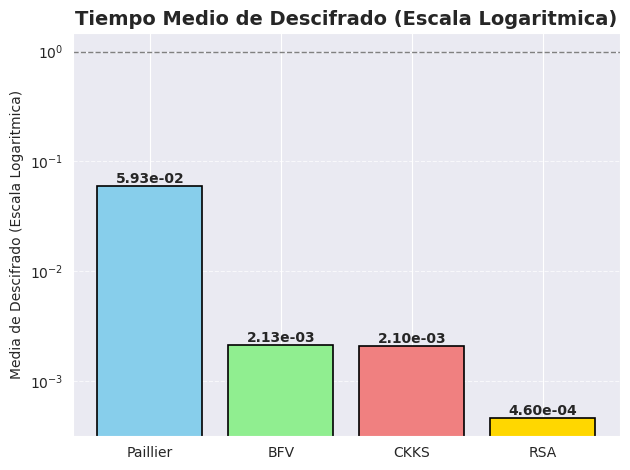

In [17]:
media_encriptado_paillier = np.mean(tiempos_desencriptado_parcial)
media_encriptado_bfv = np.mean(tiempos_desencriptado_completo_bfv)
media_encriptado_ckks = np.mean(tiempos_desencriptado_completo_ckks)
media_encriptado_rsa = np.mean(tiempos_desencriptado_asimetrico_rsa)

# Create bar plot with logarithmic scale
tags = ['Paillier', 'BFV', 'CKKS', 'RSA']
averages = [media_encriptado_paillier, media_encriptado_bfv, media_encriptado_ckks, media_encriptado_rsa]

titulo = 'Tiempo Medio de Descifrado (Escala Logaritmica)'
colores = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
ylabel = 'Media de Descifrado (Escala Logaritmica)'

barplot_tiempos(titulo, averages, tags, ylabel, colores=colores, escala_log=True)

## Además verificamos la presición de los numeros

Para números con decimales

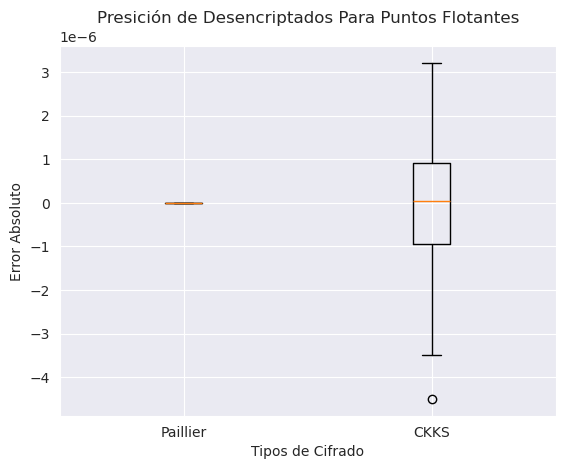

In [18]:
metodos = [numeros_desencriptados_parcial, numeros_desencriptados_completo_ckks]
boxplot_precision(metodos, numeros_random_floats, ['Paillier', 'CKKS'],
                  'Presición de Desencriptados Para Puntos Flotantes', 'Tipos de Cifrado', 'Error Absoluto')

Para números enteros

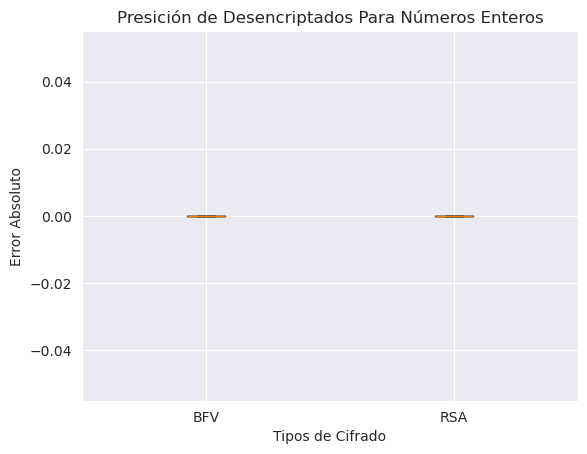

In [19]:
metodos = [numeros_desencriptados_completo_bfv, numeros_desencriptados_asimetrico_rsa]
boxplot_precision(metodos, numeros_random_enteros, ['BFV', 'RSA'], 'Presición de Desencriptados Para Números Enteros',
                  'Tipos de Cifrado', 'Error Absoluto')

# Análisis de tiempos de suma

In [20]:
mitad = len(numeros_encriptados_parcial) // 2
numeros_encriptados_parcial1 = numeros_encriptados_parcial[mitad:]
numeros_encriptados_parcial2 = numeros_encriptados_parcial[:mitad]

tiempo_suma_encriptados_parcial, suma_encriptada_parcial = tiempos_suma(numeros_encriptados_parcial1,
                                                                        numeros_encriptados_parcial2)

In [21]:
mitad = len(numeros_encriptados_completo_bfv) // 2
numeros_encriptados_completo_bfv1 = numeros_encriptados_completo_bfv[mitad:]
numeros_encriptados_completo_bfv2 = numeros_encriptados_completo_bfv[:mitad]

tiempo_suma_encriptados_completo_bfv, suma_encriptada_completo_bfv = tiempos_suma(numeros_encriptados_completo_bfv1,
                                                                                  numeros_encriptados_completo_bfv2)

In [22]:
mitad = len(numeros_encriptados_completo_ckks) // 2
numeros_encriptados_completo_ckks1 = numeros_encriptados_completo_ckks[mitad:]
numeros_encriptados_completo_ckks2 = numeros_encriptados_completo_ckks[:mitad]

tiempo_suma_encriptados_completo_ckks, suma_encriptada_completo_ckks = tiempos_suma(numeros_encriptados_completo_ckks1,
                                                                                    numeros_encriptados_completo_ckks2)

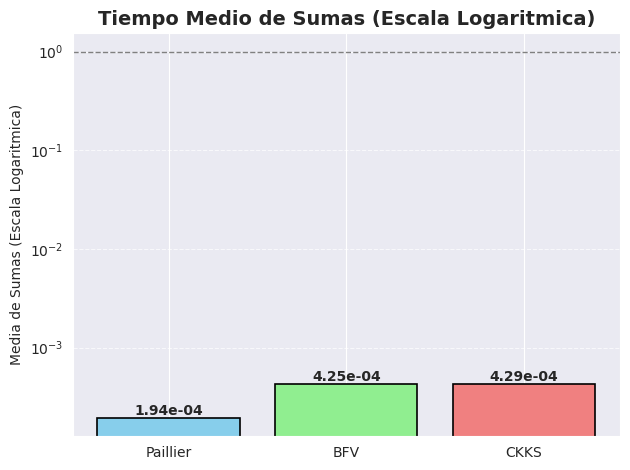

In [23]:
media_suma_paillier = np.mean(tiempo_suma_encriptados_parcial)
media_suma_bfv = np.mean(tiempo_suma_encriptados_completo_bfv)
media_suma_ckks = np.mean(tiempo_suma_encriptados_completo_ckks)

tags = ['Paillier', 'BFV', 'CKKS']
averages = [media_suma_paillier, media_suma_bfv, media_suma_ckks]

titulo = 'Tiempo Medio de Sumas (Escala Logaritmica)'
colores = ['skyblue', 'lightgreen', 'lightcoral']
ylabel = 'Media de Sumas (Escala Logaritmica)'

barplot_tiempos(titulo, averages, tags, ylabel, colores, escala_log=True)

In [24]:
def sumar_mitades(lista_de_numeros):
    midpoint = len(lista_de_numeros) // 2

    first_half = lista_de_numeros[:midpoint]
    second_half = lista_de_numeros[midpoint:]

    return [a + b for a, b in zip(first_half, second_half)]

In [25]:
sumas_random_enteros = sumar_mitades(numeros_random_enteros)
sumas_random_floats = sumar_mitades(numeros_random_floats)

In [26]:
def desencriptar_numeros(cifrador, lista_de_numeros):
    numeros_desencriptados = []
    for numero in lista_de_numeros:
        numeros_desencriptados.append(cifrador.desencriptar(numero))

    return numeros_desencriptados

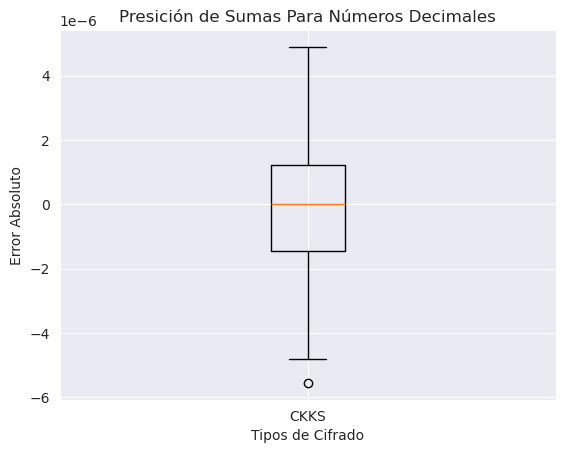

In [58]:
metodos = [desencriptar_numeros(cifrador_homomorfico_completo_ckks, suma_encriptada_completo_ckks)]
boxplot_precision(metodos, sumas_random_floats, ['CKKS'], 'Presición de Sumas Para Números Decimales',
                  'Tipos de Cifrado', 'Error Absoluto')

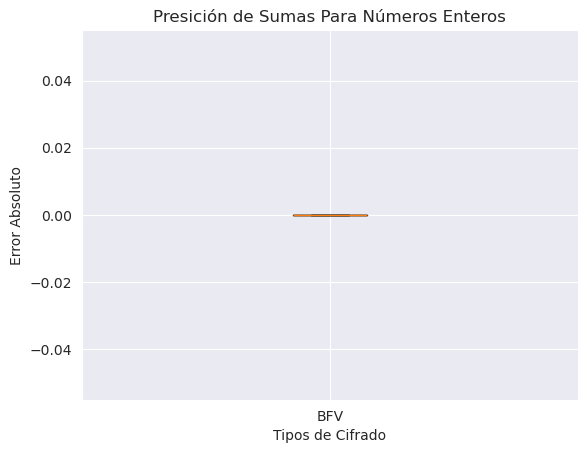

In [28]:
metodos = [desencriptar_numeros(cifrador_homomorfico_completo_bfv, suma_encriptada_completo_bfv)]
boxplot_precision(metodos, sumas_random_enteros, ['BFV'], 'Presición de Sumas Para Números Enteros',
                  'Tipos de Cifrado', 'Error Absoluto')

# Análisis de tiempos de resta

In [29]:
tiempo_resta_encriptados_parcial, resta_encriptada_parcial = tiempos_resta(numeros_encriptados_parcial1,
                                                                           numeros_encriptados_parcial2)

In [30]:
tiempo_resta_encriptados_completo_bfv, resta_encriptada_completo_bfv = tiempos_resta(numeros_encriptados_completo_bfv1,
                                                                                     numeros_encriptados_completo_bfv2)

In [31]:
tiempo_resta_encriptados_completo_ckks, resta_encriptada_completo_ckks = tiempos_resta(
    numeros_encriptados_completo_ckks1,
    numeros_encriptados_completo_ckks2)

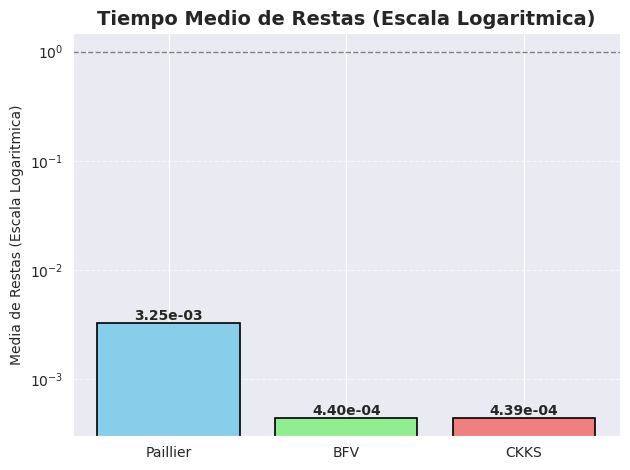

In [32]:
media_resta_paillier = np.mean(tiempo_resta_encriptados_parcial)
media_resta_bfv = np.mean(tiempo_resta_encriptados_completo_bfv)
media_resta_ckks = np.mean(tiempo_resta_encriptados_completo_ckks)

tags = ['Paillier', 'BFV', 'CKKS']
averages = [media_resta_paillier, media_resta_bfv, media_resta_ckks]

titulo = 'Tiempo Medio de Restas (Escala Logaritmica)'
colores = ['skyblue', 'lightgreen', 'lightcoral']
ylabel = 'Media de Restas (Escala Logaritmica)'

barplot_tiempos(titulo, averages, tags, ylabel, colores, escala_log=True)

In [35]:
def restar_mitades(lista_de_numeros):
    midpoint = len(lista_de_numeros) // 2

    first_half = lista_de_numeros[:midpoint]
    second_half = lista_de_numeros[midpoint:]

    return [b - a for a, b in zip(first_half, second_half)]

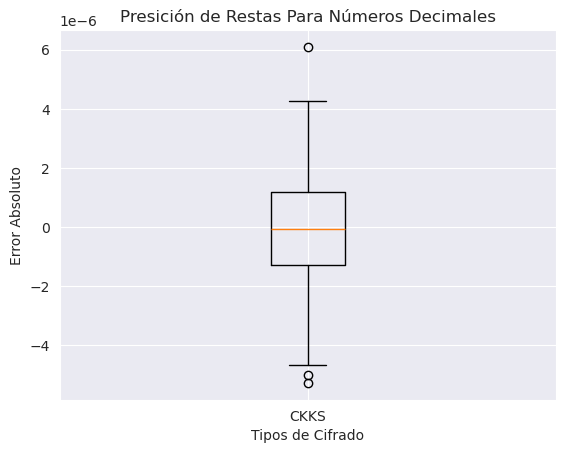

In [44]:
metodos = [desencriptar_numeros(cifrador_homomorfico_completo_ckks, resta_encriptada_completo_ckks)]
boxplot_precision(metodos, restar_mitades(numeros_random_floats), ['CKKS'], 'Presición de Restas Para Números Decimales',
                  'Tipos de Cifrado', 'Error Absoluto')

# Análisis de tiempos de multiplicación

## Multiplicación de dos números encriptados

In [37]:
tiempo_multiplicacion_encriptados_completo_bfv, multiplicacion_encriptada_completo_bfv = tiempos_multiplicacion(
    numeros_encriptados_completo_bfv1,
    numeros_encriptados_completo_bfv2)

In [38]:
tiempo_multiplicacion_encriptados_completo_ckks, multiplicacion_encriptada_completo_ckks = tiempos_multiplicacion(
    numeros_encriptados_completo_ckks1,
    numeros_encriptados_completo_ckks2)

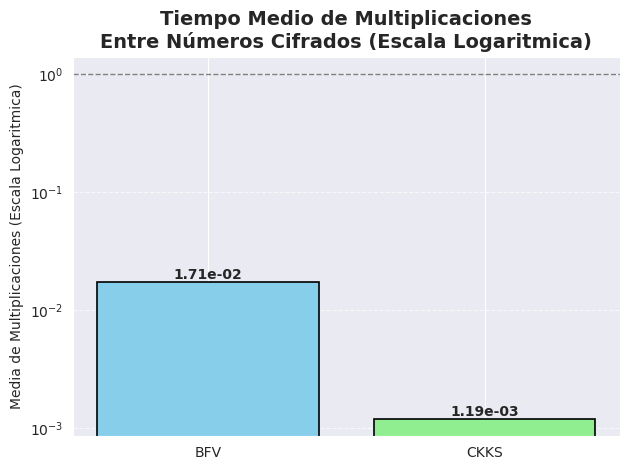

In [52]:
media_multiplicacion_encriptada_bfv = np.mean(tiempo_multiplicacion_encriptados_completo_bfv)
media_multiplicacion_encriptada_ckks = np.mean(tiempo_multiplicacion_encriptados_completo_ckks)

tags = ['BFV', 'CKKS']
averages = [media_multiplicacion_encriptada_bfv, media_multiplicacion_encriptada_ckks]

titulo = 'Tiempo Medio de Multiplicaciones\nEntre Números Cifrados (Escala Logaritmica)'
colores = ['skyblue', 'lightgreen', 'lightcoral']
ylabel = 'Media de Multiplicaciones (Escala Logaritmica)'

barplot_tiempos(titulo, averages, tags, ylabel, colores, escala_log=True)

In [47]:
def multiplicar_mitades(lista_de_numeros):
    midpoint = len(lista_de_numeros) // 2

    first_half = lista_de_numeros[:midpoint]
    second_half = lista_de_numeros[midpoint:]

    return [b * a for a, b in zip(first_half, second_half)]

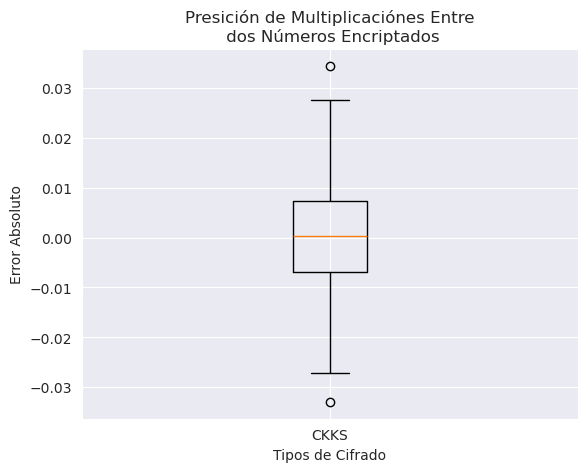

In [53]:
metodos = [desencriptar_numeros(cifrador_homomorfico_completo_ckks, multiplicacion_encriptada_completo_ckks)]
boxplot_precision(metodos, multiplicar_mitades(numeros_random_floats), ['CKKS'], 'Presición de Multiplicaciónes Entre\n dos Números Encriptados',
                  'Tipos de Cifrado', 'Error Absoluto')

## Multiplicación número encriptado con número sin encriptar

In [40]:
tiempo_multiplicacion_parcial, multiplicacion_parcial = tiempos_multiplicacion(
    numeros_encriptados_parcial,
    numeros_random_floats)

In [41]:
tiempo_multiplicacion_completo_bfv, multiplicacion_completo_bfv = tiempos_multiplicacion(
    numeros_encriptados_completo_bfv,
    numeros_random_enteros)

In [42]:
tiempo_multiplicacion_completo_ckks, multiplicacion_completo_ckks = tiempos_multiplicacion(
    numeros_encriptados_completo_ckks,
    numeros_random_floats)

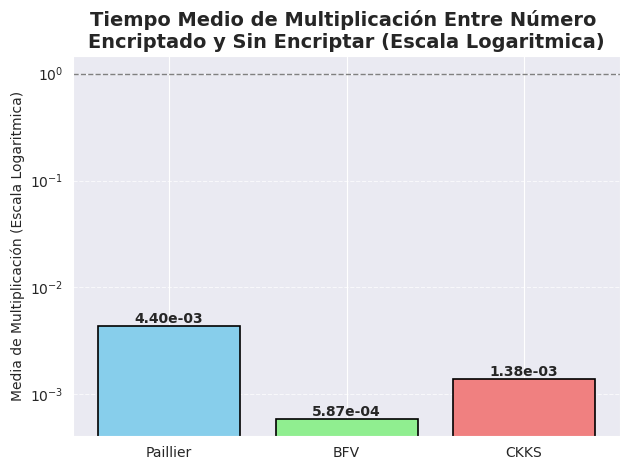

In [43]:
media_multiplicacion_paillier = np.mean(tiempo_multiplicacion_parcial)
media_multiplicacion_bfv = np.mean(tiempo_multiplicacion_completo_bfv)
media_multiplicacion_ckks = np.mean(tiempo_multiplicacion_completo_ckks)

tags = ['Paillier', 'BFV', 'CKKS']
averages = [media_multiplicacion_paillier, media_multiplicacion_bfv, media_multiplicacion_ckks]

titulo = 'Tiempo Medio de Multiplicación Entre Número \nEncriptado y Sin Encriptar (Escala Logaritmica)'
colores = ['skyblue', 'lightgreen', 'lightcoral']
ylabel = 'Media de Multiplicación (Escala Logaritmica)'

barplot_tiempos(titulo, averages, tags, ylabel, colores, escala_log=True)

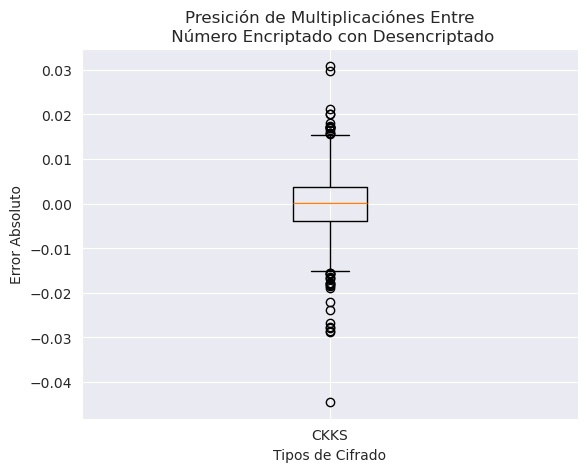

In [57]:
metodos = [desencriptar_numeros(cifrador_homomorfico_completo_ckks, multiplicacion_completo_ckks)]
boxplot_precision(metodos, np.array(numeros_random_floats) * np.array(numeros_random_floats), ['CKKS'], 'Presición de Multiplicaciónes Entre\n Número Encriptado con Desencriptado',
                  'Tipos de Cifrado', 'Error Absoluto')